# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tqdm

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import make_scorer, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

# Functions

In [2]:
def calculateVIF(data: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates the degree of multicollinearity existing among
    different variables in a dataset.
    As a reference, significance levels of multicollinearity are:
    - VIF < 5: Not significant
    - 5 < VIF < 10: Moderately significant
    - 10 < VIF: Highly significant
    Args:
    - data: pandas DataFrame containing the variables.
    returns: pandas DataFrame containing the multicollinearity level for each
    variable.
    """
    features = list(data.columns)
    num_features = len(features)

    lr_model = LinearRegression()

    result = pd.DataFrame(index=['VIF'], columns=features)
    result = result.fillna(0)

    for ite in tqdm.tqdm(range(num_features)):
        x_features = features[:]
        y_feature = features[ite]
        x_features.remove(y_feature)

        lr_model.fit(data[x_features], data[y_feature])
        result[y_feature] = 1 / (1 - lr_model.score(data[x_features], data[y_feature]))

    return result

In [3]:
def pca_variance_analysis(data: pd.DataFrame, step_size=10, target_variance=0.9) -> dict:
    """
    Simple function to explore how much of the data variance is explained
    when grouped by principal components.
    The results will be shown in a line graph.
    :param data: pd.DataFrame with the data to analyze.
    :param step_size: int, default = 10. Number of variables reduced in each step.
    :param target_variance: float, default = 0.9. Value between 0 and 1, indicates
    the target for variance explained.
    :return: dict with number of variables that explain a variance above `target_variance`.
    """
    variance_explained = []
    target = {}
    for n_features in tqdm.tqdm(range(len(data.columns), 0, -step_size)):
        pca_ = PCA(n_components=n_features)
        pca_.fit_transform(data)
        var = pca_.explained_variance_ratio_.sum()
        var_dict = {'n_features': n_features,
                    'variance': var}
        variance_explained.append(var_dict)
        if var > target_variance:
            target = var_dict

    pd.DataFrame(variance_explained).set_index('n_features').plot(figsize=(7, 5))
    plt.title('Variance explained by number of dimensions with PCA', fontsize=18)
    plt.show()

    return target

In [4]:
def score_optimization(params_, clf_, train_test: list, performance_: pd.DataFrame, scorer, model_label_: str):
    """
    This function receives a list of parameters and a classifier object and optimizes
    a predictive model based on them.
    The model returns the best performing trained model.
    :arg: params_: list of dicts with parameters to try for the model.
    :arg: clf_: model object.
    :arg: train_test: list containing train and test data in order [x_train, y_train, x_test, y_test].
    :arg: performance: pd.DataFrame where the performance of the model is stored.
    :arg: model_label: str, label to identify the model in the `performance` dataset.
    """
    x_train_, y_train_, x_test_, y_test_ = [i for i in train_test]

    # Load GridSearchCV
    search = GridSearchCV(
        estimator=clf_,
        param_grid=params_,
        n_jobs=-1,
        scoring=scorer
    )

    # Train search object
    search.fit(x_train_, y_train_)

    # Heading
    print('\n', '-' * 40, '\n', clf_.__class__.__name__, '\n', '-' * 40)

    # Extract best estimator
    best = search.best_estimator_
    print('Best parameters: \n\n', search.best_params_, '\n')

    # Cross-validate on the train data
    print("TRAIN GROUP")
    train_cv_ = cross_val_score(X=x_train_, y=y_train_,
                                estimator=best, scoring=scorer, cv=3)
    print("\nCross-validation scores:", train_cv_)
    print("Mean score:", train_cv_.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred_ = best.fit(x_train_, y_train_).predict(x_test_)
    print("\nScore:", scorer(best, x_test_, y_pred_))

    # Get classification report
    # print(classification_report(y_test, y_pred_))

    # Print confusion matrix
    conf_matrix_ = confusion_matrix(y_test_.values.argmax(axis=1), y_pred_.argmax(axis=1))
    plt.figure(figsize=(25, 25))
    sns.heatmap(conf_matrix_, annot=False, fmt='d')
    plt.show()

    # Store results
    performance_.loc[clf_.__class__.__name__ + model_label_, :] = [
        train_cv_.mean(),
        scorer(best, x_test_, y_pred_)
    ]
    # Look at the parameters for the top best scores
    display(pd.DataFrame(search.cv_results_).iloc[:, 4:].sort_values(by='rank_test_score').head())
    display(performance_)

    return best, performance_

# Data loading

In [5]:
X = pd.read_csv('train_data.csv')
y = pd.read_csv('train_targets.csv')

# Features engineering

## Initial transformations

At first, we will apply the same basic transformations done during the EDA:
- Simplify the **id** column and setting it as index.
- Create dummy variables from **group** and **dose** variables.

In [6]:
X_features = X.copy()
y_features = y.copy()

In [7]:
X_features['id'] = X['id'].str.split('-', expand=True)[0]
X_features.set_index('id', inplace=True)
y_features['id'] = y['id'].str.split('-', expand=True)[0]
y_features.set_index('id', inplace=True)

In [8]:
X_features['group'] = pd.get_dummies(X['group'], drop_first=True).values
X_features['dose'] = pd.get_dummies(X['dose'], drop_first=True).values

In [9]:
X_features.head()

,group,time,dose,gen-A,gen-B,gen-C,gen-D,gen-E,gen-F,gen-G,...,cell-CM,cell-CN,cell-CO,cell-CP,cell-CQ,cell-CR,cell-CS,cell-CT,cell-CU,cell-CV
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,1,72,1,34.42,-29.03,18.05,-25.10,-65.46,45.64,-10.70,...,24.060,49.310,-38.95,-1.680,-40.720,27.790,-33.190,29.110,-16.460,7.605
cb5223fc,1,48,0,44.37,-96.63,-15.40,-80.90,-63.53,51.57,86.05,...,-3.570,18.480,-5.99,23.500,47.355,-12.725,22.775,25.090,47.615,86.250
cb4eefd4,1,48,0,-44.21,18.49,-56.30,-30.42,45.53,36.99,53.55,...,-17.490,23.075,32.09,8.340,11.505,-36.765,-18.080,17.290,19.605,-13.330
cb597490,1,72,1,74.55,9.17,-23.59,64.05,-7.77,29.50,18.01,...,58.550,45.470,-34.90,-33.865,82.400,43.045,17.040,30.080,50.950,1.190
cb54218e,1,48,1,-9.22,4.81,-28.27,50.63,8.17,37.92,-18.90,...,36.455,62.700,10.43,36.790,26.835,8.430,48.200,8.795,56.500,44.490


## Multicollinearity exploration with VIF

VIF (Variance Inflation Factor) can show us if some variables from our dataset have a **high linear dependency** from each other.

Multicollinearity is known to cause **type II errors**, so it is a good idea to reduce it by selecting only features with a low VIF value.

In [10]:
# Function that will return VIF score for each original variable
X_VIF = calculateVIF(X_features)

100%|██████████| 875/875 [55:18<00:00,  3.79s/it]


In [11]:
X_VIF

,group,time,dose,gen-A,gen-B,gen-C,gen-D,gen-E,gen-F,gen-G,...,cell-CM,cell-CN,cell-CO,cell-CP,cell-CQ,cell-CR,cell-CS,cell-CT,cell-CU,cell-CV
VIF,1.55962,1.957306,3.369881,8.068402,2.659297,2.076038,2.325979,2.806296,2.168436,3.266073,...,16.478887,14.601478,12.470082,14.437124,18.50262,8.07982,13.4784,11.663914,9.544971,7.036768


As a reference, significance levels of multicollinearity are:
   - VIF < 5: Not significant
   - 5 < VIF < 10: Moderately significant
   - 10 < VIF: Highly significant

We are going to try sticking with features under 5 and under 10 and compare results later with each selection.

In [12]:
print(f'Number of variables with a VIF over 10: {(X_VIF.values > 10).sum()}')
print(f'Number of variables with a VIF over 5: {(X_VIF.values > 5).sum()}')

Number of variables with a VIF over 10: 93
Number of variables with a VIF over 5: 261


In [13]:
VIF_10 = [col for col in X_VIF if X_VIF.loc['VIF', col] < 10]
VIF_5 = [col for col in X_VIF if X_VIF.loc['VIF', col] < 5]

X_features_VIF10 = X_features[VIF_10]
X_features_VIF5 = X_features[VIF_5]

In [14]:
X_features_VIF5.head()

,group,time,dose,gen-B,gen-C,gen-D,gen-E,gen-F,gen-G,gen-J,...,gen-ACJ,gen-ACK,gen-ACL,gen-ACM,gen-ACN,gen-ACO,gen-ACP,gen-ACR,cell-BG,cell-BW
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,1,72,1,-29.03,18.05,-25.10,-65.46,45.64,-10.70,-21.01,...,-2.80,20.97,-89.53,-63.27,-111.40,136.50,89.03,12.42,-7.175,18.615
cb5223fc,1,48,0,-96.63,-15.40,-80.90,-63.53,51.57,86.05,18.37,...,-26.47,-111.50,48.76,-171.60,-56.64,-28.22,-41.12,-37.23,27.285,13.030
cb4eefd4,1,48,0,18.49,-56.30,-30.42,45.53,36.99,53.55,-26.06,...,-44.42,14.74,-115.00,-48.16,5.54,-10.82,-37.71,12.66,-62.800,26.070
cb597490,1,72,1,9.17,-23.59,64.05,-7.77,29.50,18.01,-64.91,...,-13.80,-43.96,10.10,-108.30,-46.39,-10.30,-163.50,-69.84,-39.720,-4.505
cb54218e,1,48,1,4.81,-28.27,50.63,8.17,37.92,-18.90,-32.82,...,64.38,-62.23,-105.50,-181.20,3.49,102.30,-11.03,40.96,43.520,19.865


In [15]:
X_features_VIF10.head()

,group,time,dose,gen-A,gen-B,gen-C,gen-D,gen-E,gen-F,gen-G,...,cell-BW,cell-BY,cell-BZ,cell-CI,cell-CJ,cell-CK,cell-CL,cell-CR,cell-CU,cell-CV
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,1,72,1,34.42,-29.03,18.05,-25.10,-65.46,45.64,-10.70,...,18.615,-26.220,26.265,-10.980,10.480,18.425,14.005,27.790,-16.460,7.605
cb5223fc,1,48,0,44.37,-96.63,-15.40,-80.90,-63.53,51.57,86.05,...,13.030,-4.985,25.695,-27.415,-1.610,-36.740,0.485,-12.725,47.615,86.250
cb4eefd4,1,48,0,-44.21,18.49,-56.30,-30.42,45.53,36.99,53.55,...,26.070,-44.750,-16.190,39.000,19.095,13.050,11.090,-36.765,19.605,-13.330
cb597490,1,72,1,74.55,9.17,-23.59,64.05,-7.77,29.50,18.01,...,-4.505,4.615,25.505,-5.165,-9.220,32.525,30.325,43.045,50.950,1.190
cb54218e,1,48,1,-9.22,4.81,-28.27,50.63,8.17,37.92,-18.90,...,19.865,31.375,12.300,-49.795,49.165,-32.130,20.305,8.430,56.500,44.490


## Dimensionality reduction with PCA

PCA (Principal Components Analysis) is a method to combine the variables of a dataset by combining them linearly in such a way that they capture as much variance as possible with a reduced amount of dimensions.

This method is useful to reduce computing complexity as well as creating clearer visualizations with a reduced number of variables.

100%|██████████| 88/88 [08:10<00:00,  5.58s/it]


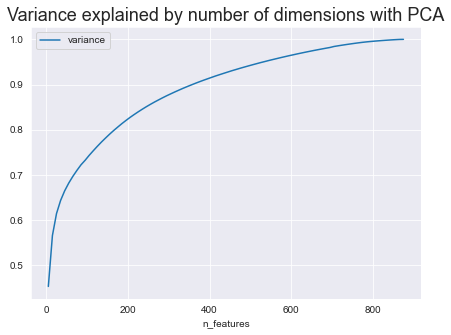

{'n_features': 365, 'variance': 0.9027016260152394}

In [16]:
pca_variance_analysis(X_features)

100%|██████████| 79/79 [05:11<00:00,  3.94s/it]


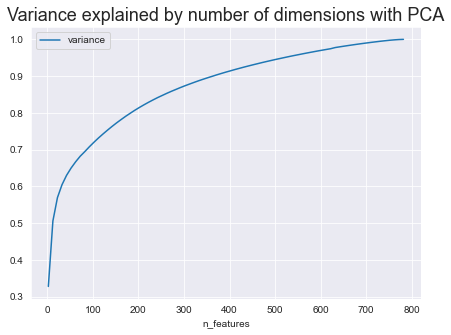

{'n_features': 372, 'variance': 0.9034227101506237}

In [17]:
pca_variance_analysis(X_features_VIF10)

100%|██████████| 62/62 [02:41<00:00,  2.60s/it]


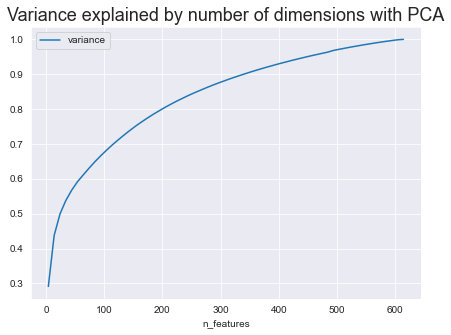

{'n_features': 344, 'variance': 0.9024007898653321}

In [18]:
pca_variance_analysis(X_features_VIF5)

From the plots above we can't se an obvious point where a dimensionality reduction using principal components would create a big advantage.

However, 90% of the variance seems to be consistently explained by a little over 300 dimensions. This could be useful in case we want to do a first round of models training with a less computing demanding dataset.

In [19]:
pca = PCA(n_components=344)
pca_features = pca.fit_transform(X_features_VIF5)

In [20]:
pca_features = pd.DataFrame(pca_features, index=X_features.index)
pca_features.head()

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,-370.042681,51.736403,-232.213564,-211.579162,-107.258948,179.656453,90.189819,35.034952,-95.279141,247.102036,...,129.140139,94.433893,-11.851977,-86.325116,55.119843,42.086559,-59.019826,61.912824,-67.365829,-101.742623
cb5223fc,-241.559780,17.664675,334.589491,-314.667482,54.481023,608.119455,699.242031,-58.364446,-178.925131,139.588806,...,88.622730,38.986431,-51.564817,3.743955,25.649411,93.843328,4.181404,8.968303,85.988131,-109.948814
cb4eefd4,-284.725948,277.395323,217.875026,-409.577798,32.245703,-192.532818,-28.259020,234.848225,92.997686,-223.032927,...,-0.239411,13.846322,40.362354,-49.609136,23.242647,1.785001,-74.187372,-53.940912,32.513255,-62.595690
cb597490,-263.605767,141.539040,219.691697,-406.484211,66.752833,327.338297,-58.944334,92.370577,-212.864337,-104.082316,...,-7.971930,68.807337,-11.773985,-69.926164,34.858028,-48.123039,-68.330814,52.238206,-64.298456,27.433462
cb54218e,103.497271,217.586189,-191.582942,-446.570512,70.625349,173.525545,-188.675958,361.366348,-390.420616,-346.555324,...,43.426929,-80.953317,217.725068,-95.436946,35.481837,-53.397169,107.766843,55.646986,189.725515,-52.888866


We will try a first approach to find a prediction model using the **90% more significant dimensions** from the PCA.

## Rescaling the data

To avoid some features having a bigger weight than others, all of them are going to be rescaled, so they have the same numerical ranges.

This step will be done again for each new aggregation method besides the PCA dimensionality reduction.

In [21]:
pca_scaler = RobustScaler()
scaled_features = pca_scaler.fit_transform(pca_features)
scaled_features = pd.DataFrame(scaled_features, index=X_features.index)
scaled_features.head()

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,-0.162014,-0.068735,-0.447192,-0.362570,-0.282581,0.447610,0.326305,0.149403,-0.394818,0.666053,...,1.657653,1.219019,-0.152416,-1.124317,0.706434,0.557055,-0.771896,0.810699,-0.876455,-1.335868
cb5223fc,0.220606,-0.205409,0.614480,-0.551442,0.294237,1.351648,2.395444,-0.206993,-0.672668,0.355709,...,1.137800,0.506476,-0.667040,0.049891,0.326849,1.233901,0.050685,0.116182,1.126228,-1.444531
cb4eefd4,0.092058,0.836462,0.395864,-0.725331,0.214938,-0.337693,-0.076102,0.911858,0.230590,-0.691024,...,-0.002336,0.183406,0.524211,-0.645660,0.295849,0.030013,-0.969306,-0.709050,0.427888,-0.817503
cb597490,0.154954,0.291495,0.399266,-0.719663,0.338002,0.759212,-0.180350,0.368187,-0.785405,-0.347665,...,-0.101547,0.889698,-0.151405,-0.910528,0.445458,-0.622656,-0.893081,0.683789,-0.836397,0.374620
cb54218e,1.248181,0.596547,-0.371087,-0.793106,0.351813,0.434674,-0.621088,1.394631,-1.375202,-1.047580,...,0.557920,-1.034843,2.822589,-1.243105,0.453492,-0.691628,1.398877,0.728505,2.480956,-0.688970


## Train test split

The dataset is going to be split into training and testing data, to check for overfitting in the models.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(scaled_features, y_features)

## Balance the dataset

Since the target variables are **not uniformly represented** in our data, it is a good idea to **balance the dataset** so all of them have a similar representation.

However, after doing some research, the author wasn't able to find a **reliable** mechanism for balancing multilabel datasets. This is a **point for improvement** if additional time is to be put into this work.

# Models training

We have done a selection of models better suited for **multi-label classification** problems, as indicated in the [Scikit-Learn](https://scikit-learn.org/stable/modules/multiclass.html) documentation.

The general strategy that we are going to follow is repeating the training process with each subselection of variables: **PCA reduced**, **VIF < 5** and **VIF < 10**.

We will also apply some **hyper parameters tuning** with a **Grid Search** function, to look for the best parameters configuration on each model.

In [23]:
models = []
log_scorer = make_scorer(log_loss, greater_is_better=False)
performance = pd.DataFrame(columns=['train_score', 'test_score'])

## PCA reduced

In [24]:
kn_clf = KNeighborsClassifier()
rn_clf = RadiusNeighborsClassifier()
mlp_clf = MLPClassifier()
rdg_clf = RidgeClassifier()
model_label = '_pca'


 ---------------------------------------- 
 KNeighborsClassifier 
 ----------------------------------------
Best parameters: 

 {'leaf_size': 10, 'n_neighbors': 10} 

TRAIN GROUP

Cross-validation scores: [-3.50766595 -3.5002131  -3.6065083 ]
Mean score: -3.5381291139189393

TEST GROUP

Score: -0.03812818839108997


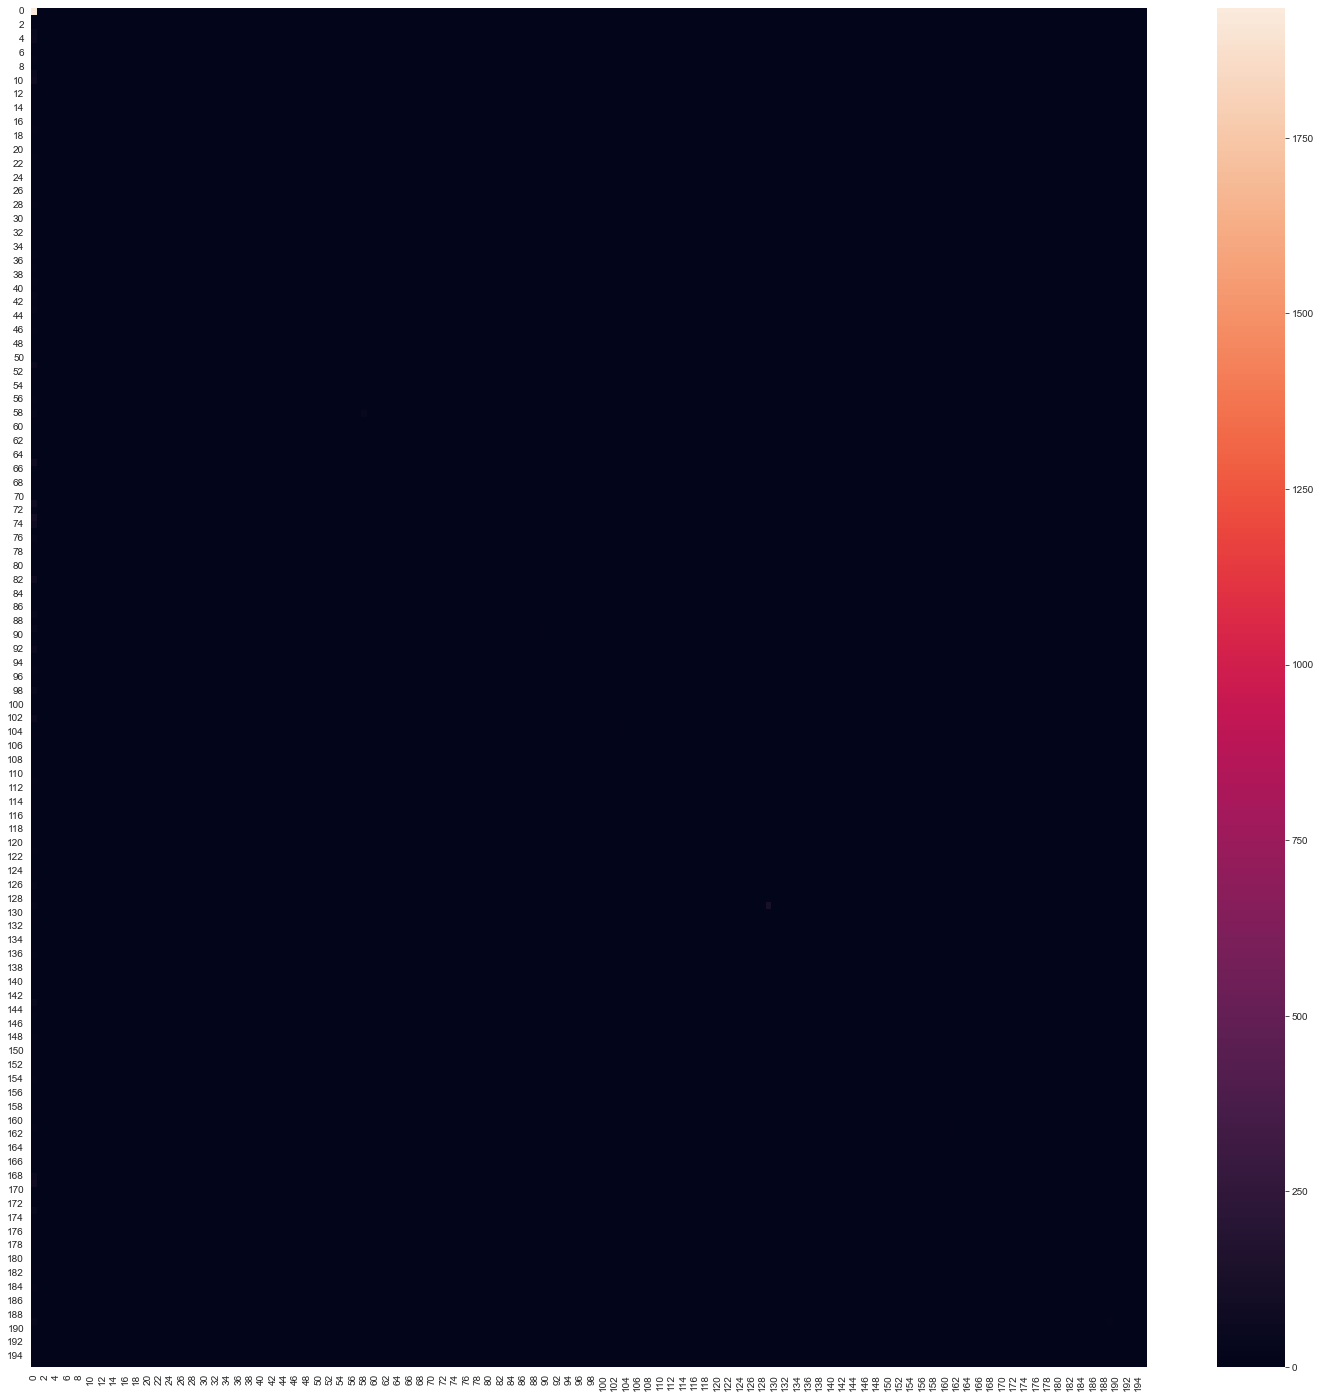

,param_leaf_size,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,10,10,"{'leaf_size': 10, 'n_neighbors': 10}",-3.412179,-3.612991,-3.417710,-3.604599,-3.585082,-3.526512,0.091560,1
6,20,10,"{'leaf_size': 20, 'n_neighbors': 10}",-3.412179,-3.612991,-3.417710,-3.604599,-3.585082,-3.526512,0.091560,1
10,30,10,"{'leaf_size': 30, 'n_neighbors': 10}",-3.412179,-3.612991,-3.417710,-3.604599,-3.585082,-3.526512,0.091560,1
14,100,10,"{'leaf_size': 100, 'n_neighbors': 10}",-3.412179,-3.612991,-3.417710,-3.604599,-3.585082,-3.526512,0.091560,1
1,10,5,"{'leaf_size': 10, 'n_neighbors': 5}",-3.468780,-3.595709,-3.534322,-3.573576,-3.555865,-3.545651,0.043422,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128


In [25]:
kn_params = {
    'n_neighbors': [1, 5, 10, 100],
    'leaf_size': [10, 20, 30, 100]
}
model, performance = score_optimization(kn_params, kn_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [        nan         nan -3.75912528         nan         nan -3.75912528
         nan         nan -3.75912528         nan         nan -3.75912528]
  warnings.warn(



 ---------------------------------------- 
 RadiusNeighborsClassifier 
 ----------------------------------------
Best parameters: 

 {'leaf_size': 10, 'radius': 100} 

TRAIN GROUP

Cross-validation scores: [-3.74170602 -3.77414533 -3.7615119 ]
Mean score: -3.7591210840135916

TEST GROUP

Score: -0.0


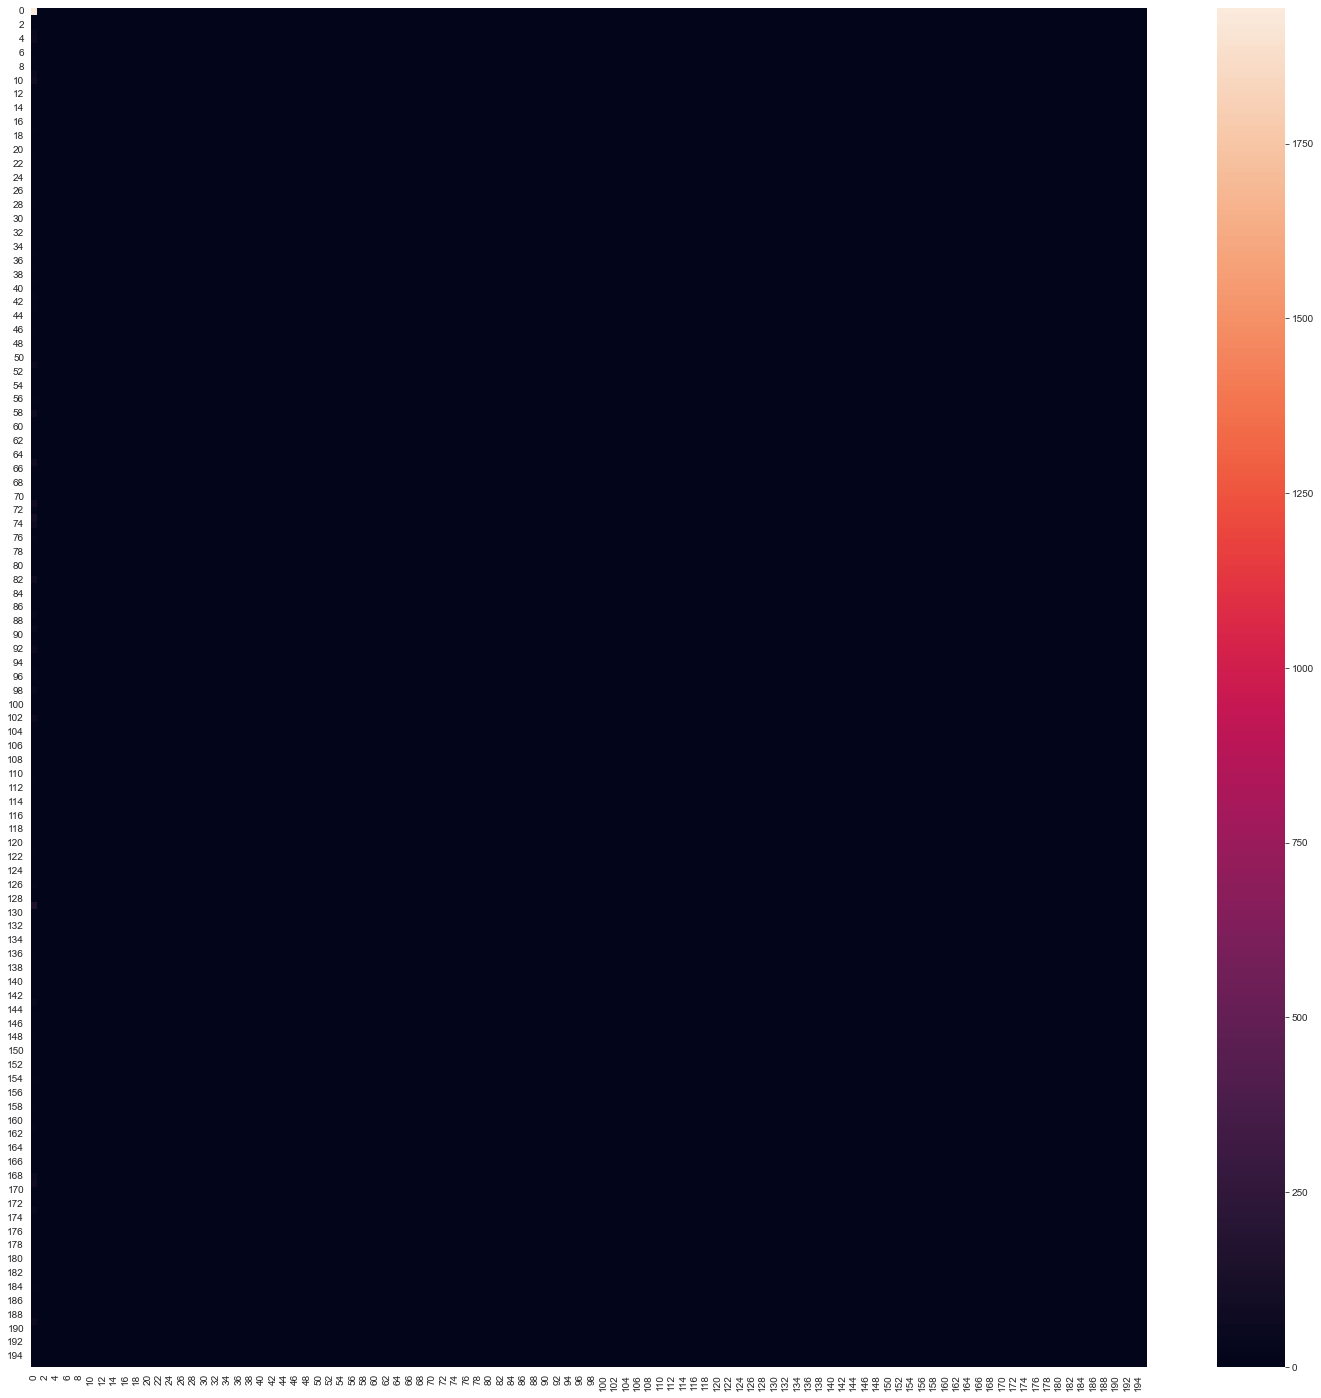

,param_leaf_size,param_radius,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,10,100,"{'leaf_size': 10, 'radius': 100}",-3.702296,-3.808555,-3.70416,-3.824807,-3.755808,-3.759125,0.051028,1
5,20,100,"{'leaf_size': 20, 'radius': 100}",-3.702296,-3.808555,-3.70416,-3.824807,-3.755808,-3.759125,0.051028,1
8,30,100,"{'leaf_size': 30, 'radius': 100}",-3.702296,-3.808555,-3.70416,-3.824807,-3.755808,-3.759125,0.051028,1
11,100,100,"{'leaf_size': 100, 'radius': 100}",-3.702296,-3.808555,-3.70416,-3.824807,-3.755808,-3.759125,0.051028,1
0,10,10,"{'leaf_size': 10, 'radius': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0


In [26]:
rn_params = {
    'radius': [10, 50, 100],
    'leaf_size': [10, 20, 30, 100]
}
model, performance = score_optimization(rn_params, rn_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



 ---------------------------------------- 
 MLPClassifier 
 ----------------------------------------
Best parameters: 

 {'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'} 

TRAIN GROUP


C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Cross-validation scores: [-5.93753848 -5.70366251 -5.93308369]
Mean score: -5.858094890914483

TEST GROUP


C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Score: -0.11520914910710661


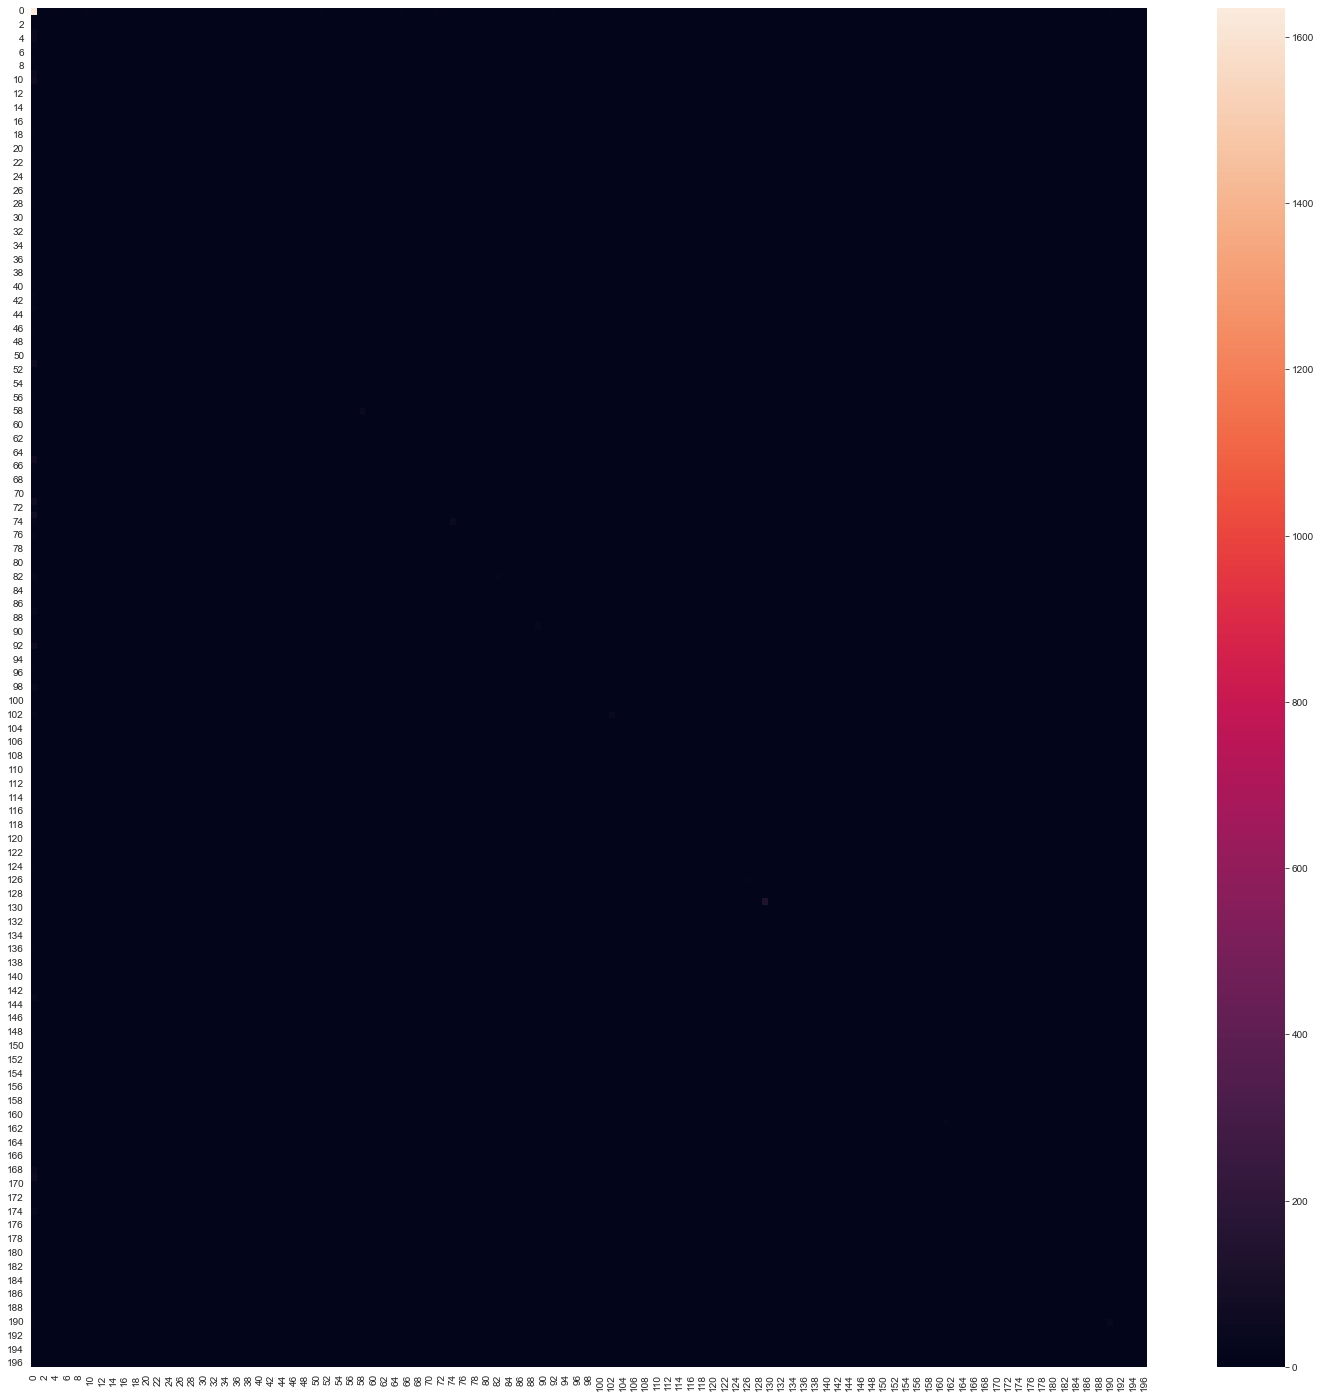

,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,adaptive,1000,sgd,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-6.074143,-6.011538,-5.503408,-6.137767,-5.877771,-5.920925,0.225783,1
2,adaptive,1000,adam,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-9.180024,-9.364167,-8.941885,-9.797930,-9.066504,-9.270102,0.298243,2
0,adaptive,1000,lbfgs,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-10.246780,-10.706491,-10.085600,-11.225387,-10.366467,-10.526145,0.404743,3


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209


In [27]:
mlp_params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['adaptive'],
    'max_iter': [1000]
}
model, performance = score_optimization(mlp_params, mlp_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)


 ---------------------------------------- 
 RidgeClassifier 
 ----------------------------------------
Best parameters: 

 {'alpha': 100, 'fit_intercept': True} 

TRAIN GROUP

Cross-validation scores: [-3.38360134 -3.43402839 -3.4939107 ]
Mean score: -3.43718014410565

TEST GROUP

Score: -0.04103873712323547


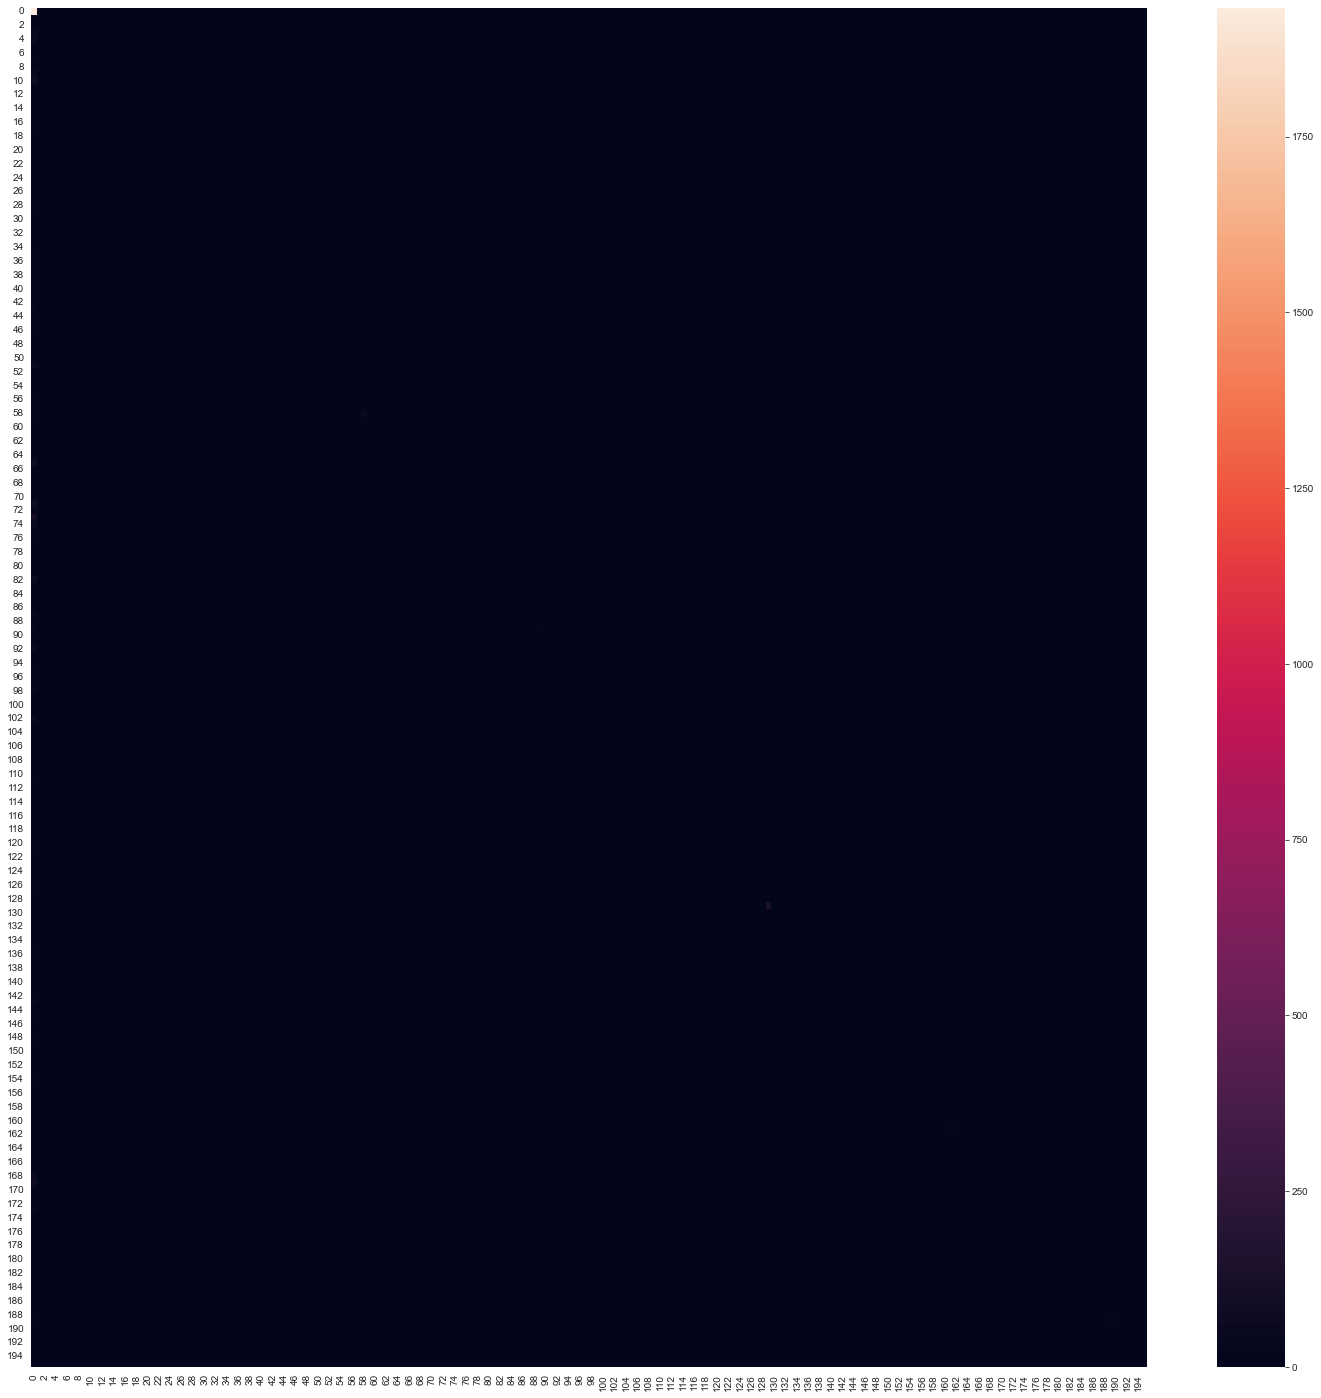

,param_alpha,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,100,True,"{'alpha': 100, 'fit_intercept': True}",-3.283854,-3.490863,-3.364345,-3.600624,-3.452756,-3.438488,0.108299,1
0,0.1,True,"{'alpha': 0.1, 'fit_intercept': True}",-3.281747,-3.487134,-3.377330,-3.608984,-3.449026,-3.440844,0.109386,2
2,1,True,"{'alpha': 1, 'fit_intercept': True}",-3.281747,-3.487134,-3.377330,-3.608984,-3.449026,-3.440844,0.109386,2
4,10,True,"{'alpha': 10, 'fit_intercept': True}",-3.281989,-3.487134,-3.379194,-3.608984,-3.449026,-3.441266,0.109101,4
7,100,False,"{'alpha': 100, 'fit_intercept': False}",-6.340865,-6.429399,-6.443534,-6.843359,-6.389419,-6.489315,0.180582,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209
RidgeClassifier_pca,-3.43718,-0.041039


In [28]:
rdg_params = {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}
model, performance = score_optimization(rdg_params, rdg_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

## VIF 5

In [29]:
vif5_scaler = RobustScaler()
scaled_features = vif5_scaler.fit_transform(X_features_VIF5)
scaled_features = pd.DataFrame(scaled_features, index=X_features.index)
scaled_features.head()

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,0.0,0.5,1.0,-0.253550,0.095934,-0.284581,-0.670231,0.419589,-0.100685,-0.348969,...,-0.019170,0.213955,-0.900761,-0.571972,-1.103231,1.776342,0.850714,0.129823,-0.078077,0.302745
cb5223fc,0.0,0.0,0.0,-0.956875,-0.205662,-0.908045,-0.649594,0.472630,0.833285,0.023454,...,-0.256737,-1.036824,0.531035,-1.576702,-0.563830,-0.373067,-0.392777,-0.340325,0.618050,0.185935
cb4eefd4,0.0,0.0,0.0,0.240857,-0.574430,-0.344022,0.516574,0.342218,0.519548,-0.396728,...,-0.436895,0.155132,-1.164467,-0.431831,0.048660,-0.146017,-0.360197,0.132096,-1.201757,0.458667
cb597490,0.0,0.5,1.0,0.143890,-0.279506,0.711508,-0.053358,0.275224,0.176465,-0.764138,...,-0.129573,-0.399112,0.130766,-0.989612,-0.462864,-0.139231,-1.562031,-0.649117,-0.735518,-0.180810
cb54218e,0.0,0.0,1.0,0.098528,-0.321702,0.561564,0.117087,0.350537,-0.179844,-0.460658,...,0.655091,-0.571617,-1.066108,-1.665739,0.028467,1.330071,-0.105288,0.400076,0.946013,0.328889


In [30]:
x_train, x_test, y_train, y_test = train_test_split(scaled_features, y_features)

In [31]:
kn_clf_vif5 = KNeighborsClassifier()
rn_clf_vif5 = RadiusNeighborsClassifier()
mlp_clf_vif5 = MLPClassifier()
rdg_clf_vif5 = RidgeClassifier()
model_label = '_vif5'


 ---------------------------------------- 
 KNeighborsClassifier 
 ----------------------------------------
Best parameters: 

 {'leaf_size': 10, 'n_neighbors': 10} 

TRAIN GROUP

Cross-validation scores: [-3.38996261 -3.38622267 -3.51770462]
Mean score: -3.431296634858679

TEST GROUP

Score: -0.04715088946073746


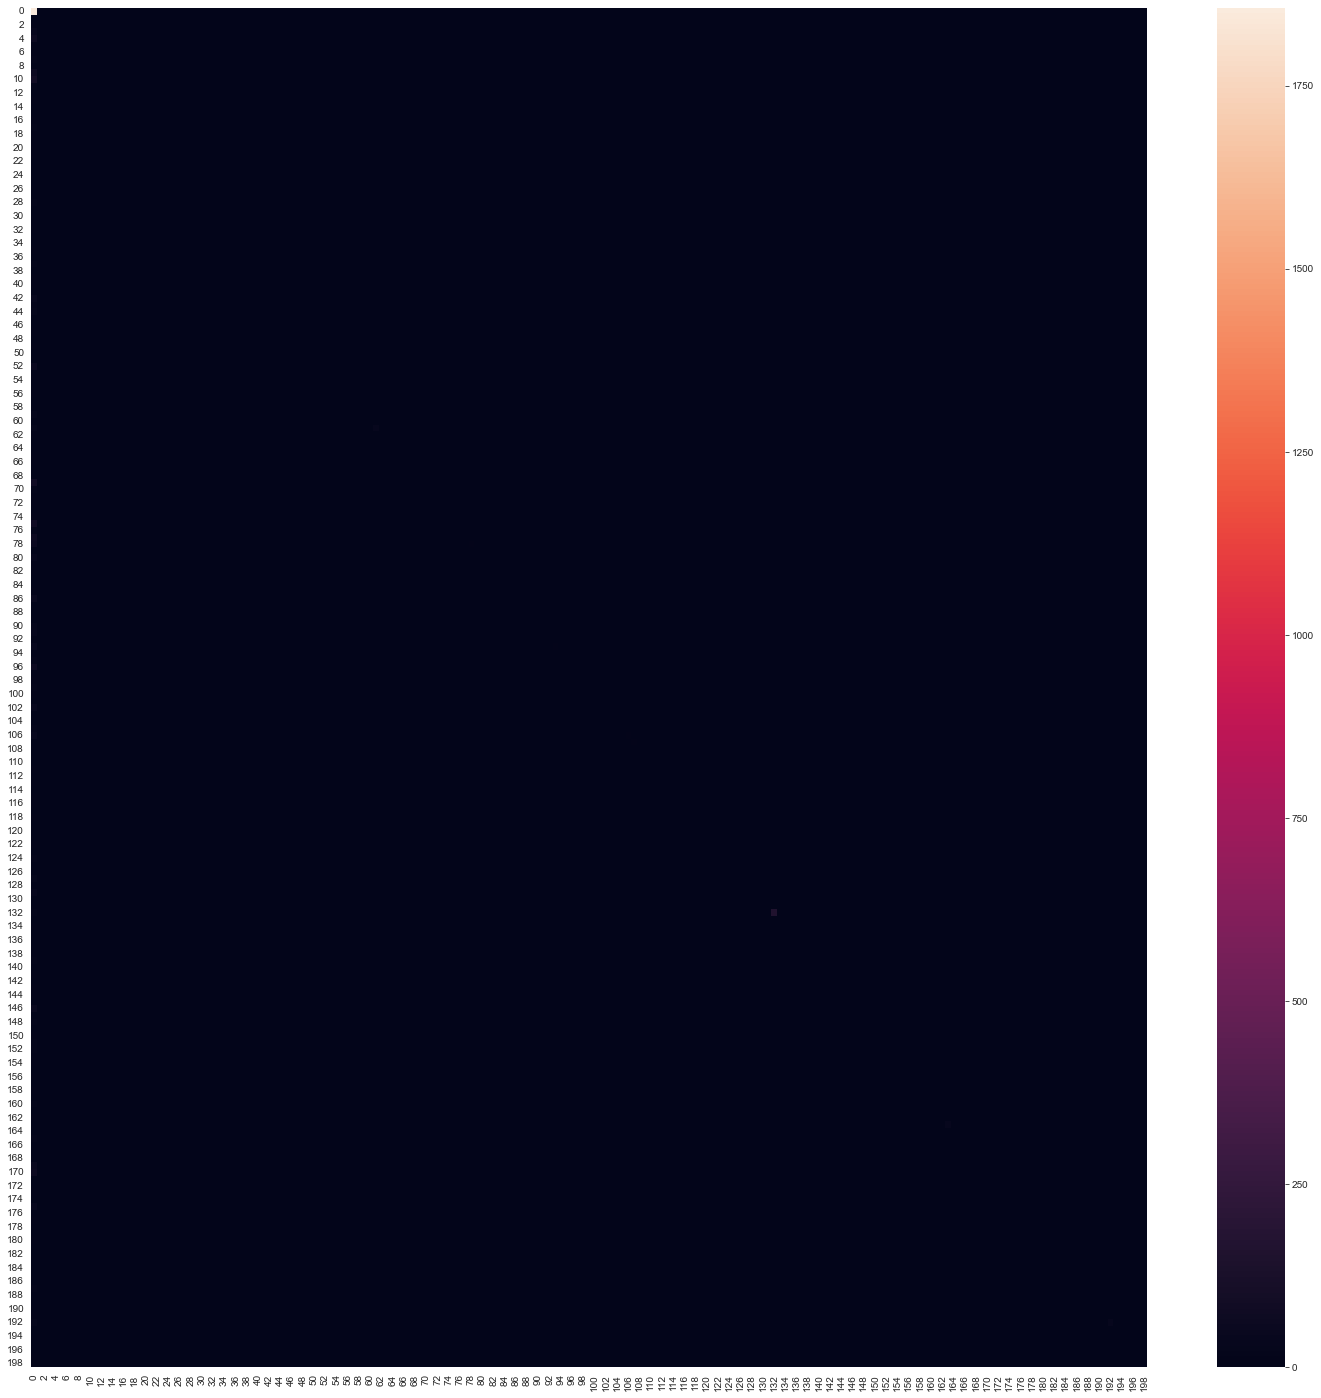

,param_leaf_size,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,10,10,"{'leaf_size': 10, 'n_neighbors': 10}",-3.240630,-3.459385,-3.438575,-3.462874,-3.510448,-3.422382,0.093873,1
6,20,10,"{'leaf_size': 20, 'n_neighbors': 10}",-3.240630,-3.459385,-3.438575,-3.462874,-3.510448,-3.422382,0.093873,1
10,30,10,"{'leaf_size': 30, 'n_neighbors': 10}",-3.240630,-3.459385,-3.438575,-3.462874,-3.510448,-3.422382,0.093873,1
14,100,10,"{'leaf_size': 100, 'n_neighbors': 10}",-3.240630,-3.459385,-3.438575,-3.462874,-3.510448,-3.422382,0.093873,1
1,10,5,"{'leaf_size': 10, 'n_neighbors': 5}",-3.341033,-3.524007,-3.505610,-3.479878,-3.467940,-3.463694,0.064375,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209
RidgeClassifier_pca,-3.43718,-0.041039
KNeighborsClassifier_vif5,-3.431297,-0.047151


In [32]:
kn_params = {
    'n_neighbors': [1, 5, 10, 100],
    'leaf_size': [10, 20, 30, 100]
}
model, performance = score_optimization(kn_params, kn_clf_vif5, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [        nan         nan -3.73066613         nan         nan -3.73066613
         nan         nan -3.73066613         nan         nan -3.73066613]
  warnings.warn(



 ---------------------------------------- 
 RadiusNeighborsClassifier 
 ----------------------------------------
Best parameters: 

 {'leaf_size': 10, 'radius': 100} 

TRAIN GROUP

Cross-validation scores: [-3.73056568 -3.73893234 -3.72250176]
Mean score: -3.7306665941246764

TEST GROUP

Score: -0.0


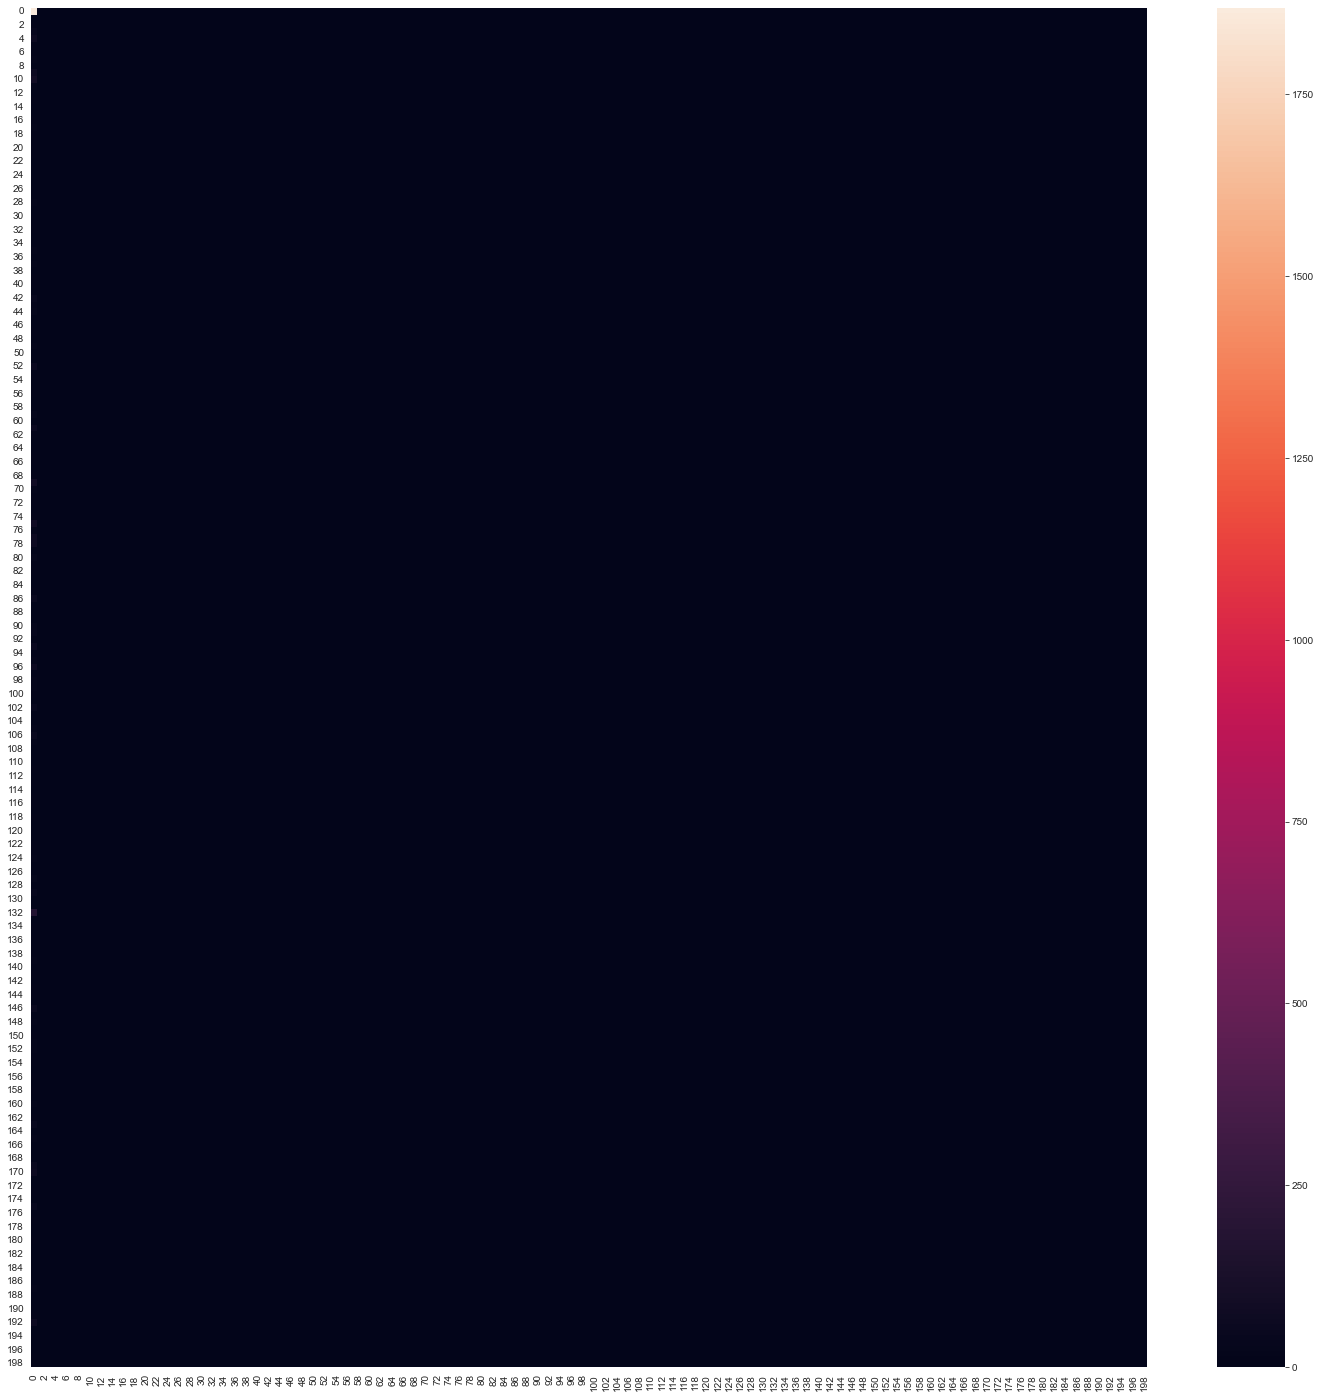

,param_leaf_size,param_radius,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,10,100,"{'leaf_size': 10, 'radius': 100}",-3.683245,-3.769892,-3.753599,-3.705942,-3.740652,-3.730666,0.0317,1
5,20,100,"{'leaf_size': 20, 'radius': 100}",-3.683245,-3.769892,-3.753599,-3.705942,-3.740652,-3.730666,0.0317,1
8,30,100,"{'leaf_size': 30, 'radius': 100}",-3.683245,-3.769892,-3.753599,-3.705942,-3.740652,-3.730666,0.0317,1
11,100,100,"{'leaf_size': 100, 'radius': 100}",-3.683245,-3.769892,-3.753599,-3.705942,-3.740652,-3.730666,0.0317,1
0,10,10,"{'leaf_size': 10, 'radius': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209
RidgeClassifier_pca,-3.43718,-0.041039
KNeighborsClassifier_vif5,-3.431297,-0.047151
RadiusNeighborsClassifier_vif5,-3.730667,-0.0


In [33]:
rn_params = {
    'radius': [10, 50, 100],
    'leaf_size': [10, 20, 30, 100]
}
model, performance = score_optimization(rn_params, rn_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



 ---------------------------------------- 
 MLPClassifier 
 ----------------------------------------
Best parameters: 

 {'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'} 

TRAIN GROUP


C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Cross-validation scores: [-5.97499339 -5.92609634 -6.25406071]
Mean score: -6.051716813602347

TEST GROUP


C:\Users\jfcaliz\Anaconda3\envs\Devo_tech_test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Score: -0.15964399904256654


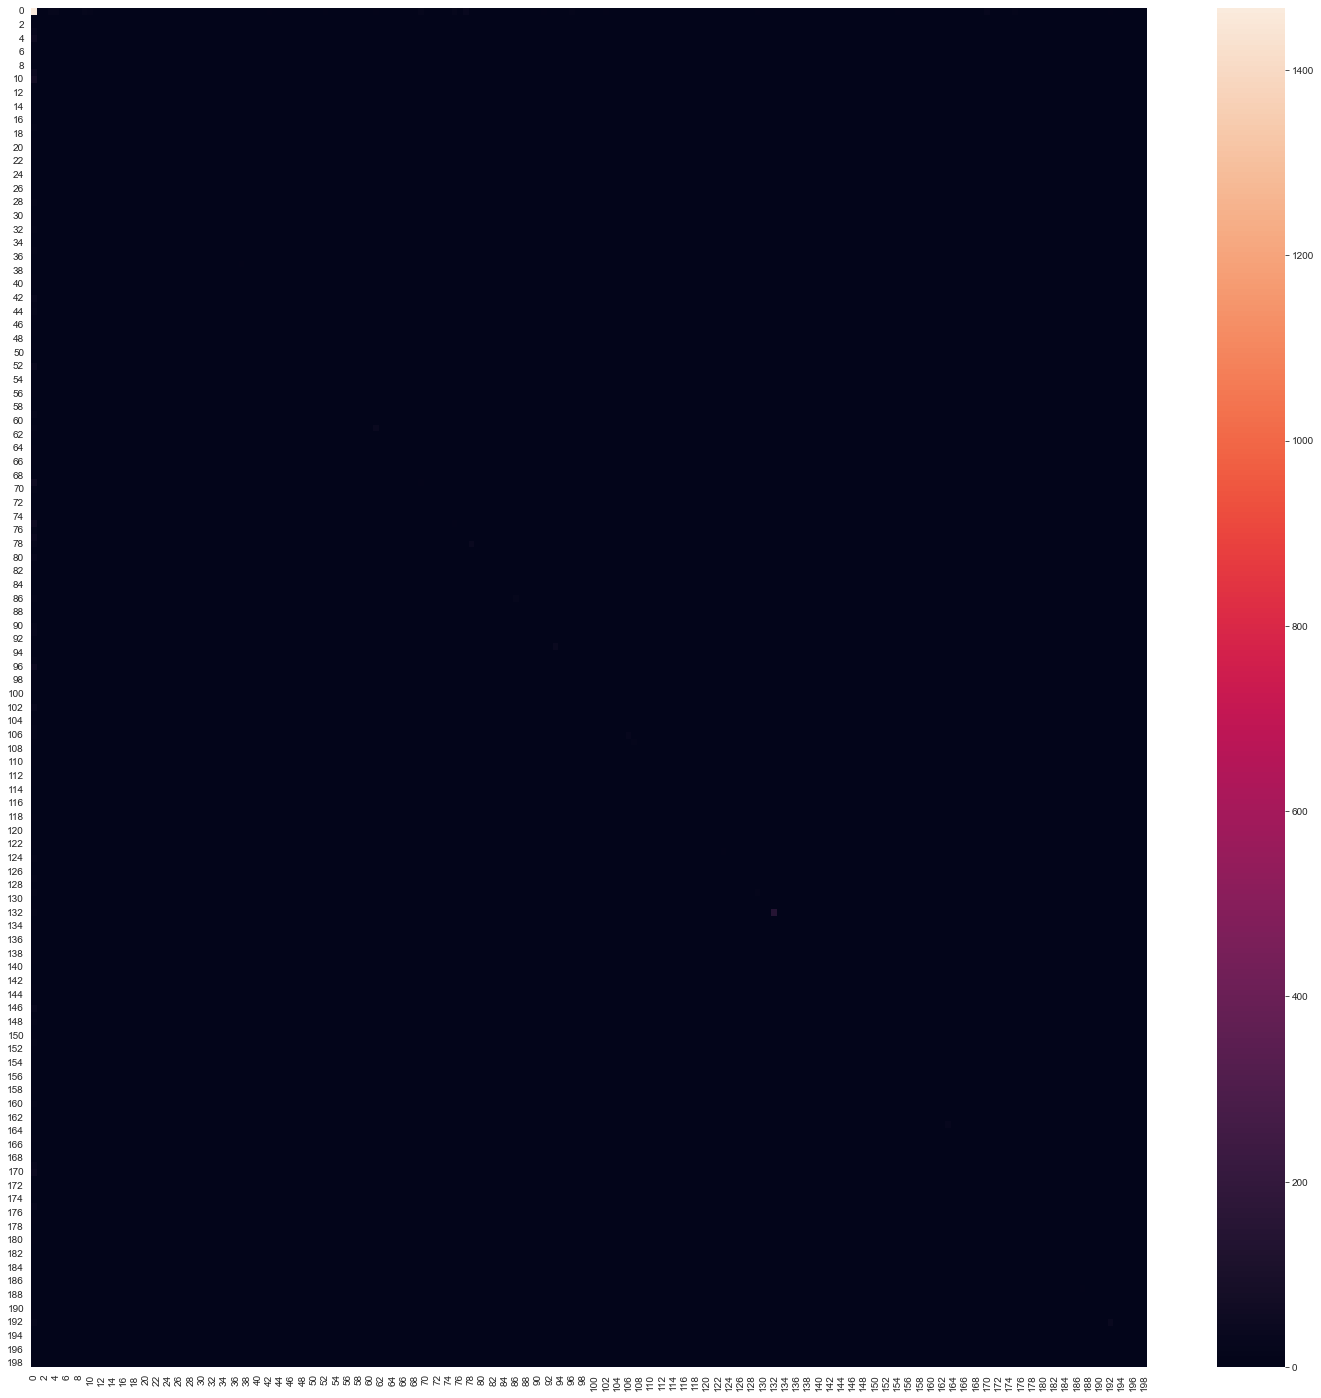

,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,adaptive,1000,sgd,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-6.119884,-6.544745,-6.280849,-6.458740,-6.365714,-6.353986,0.146733,1
2,adaptive,1000,adam,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-7.385768,-7.806651,-7.389107,-7.360504,-6.866394,-7.361685,0.298208,2
0,adaptive,1000,lbfgs,"{'learning_rate': 'adaptive', 'max_iter': 1000...",-8.486196,-9.467160,-8.039577,-8.596569,-8.892147,-8.696330,0.472854,3


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209
RidgeClassifier_pca,-3.43718,-0.041039
KNeighborsClassifier_vif5,-3.431297,-0.047151
RadiusNeighborsClassifier_vif5,-3.730667,-0.0
MLPClassifier_vif5,-6.051717,-0.159644


In [34]:
mlp_params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['adaptive'],
    'max_iter': [1000]
}
model, performance = score_optimization(mlp_params, mlp_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)


 ---------------------------------------- 
 RidgeClassifier 
 ----------------------------------------
Best parameters: 

 {'alpha': 0.1, 'fit_intercept': True} 

TRAIN GROUP

Cross-validation scores: [-3.36151889 -3.32000862 -3.4407148 ]
Mean score: -3.3740807686836116

TEST GROUP

Score: -0.04540456022145183


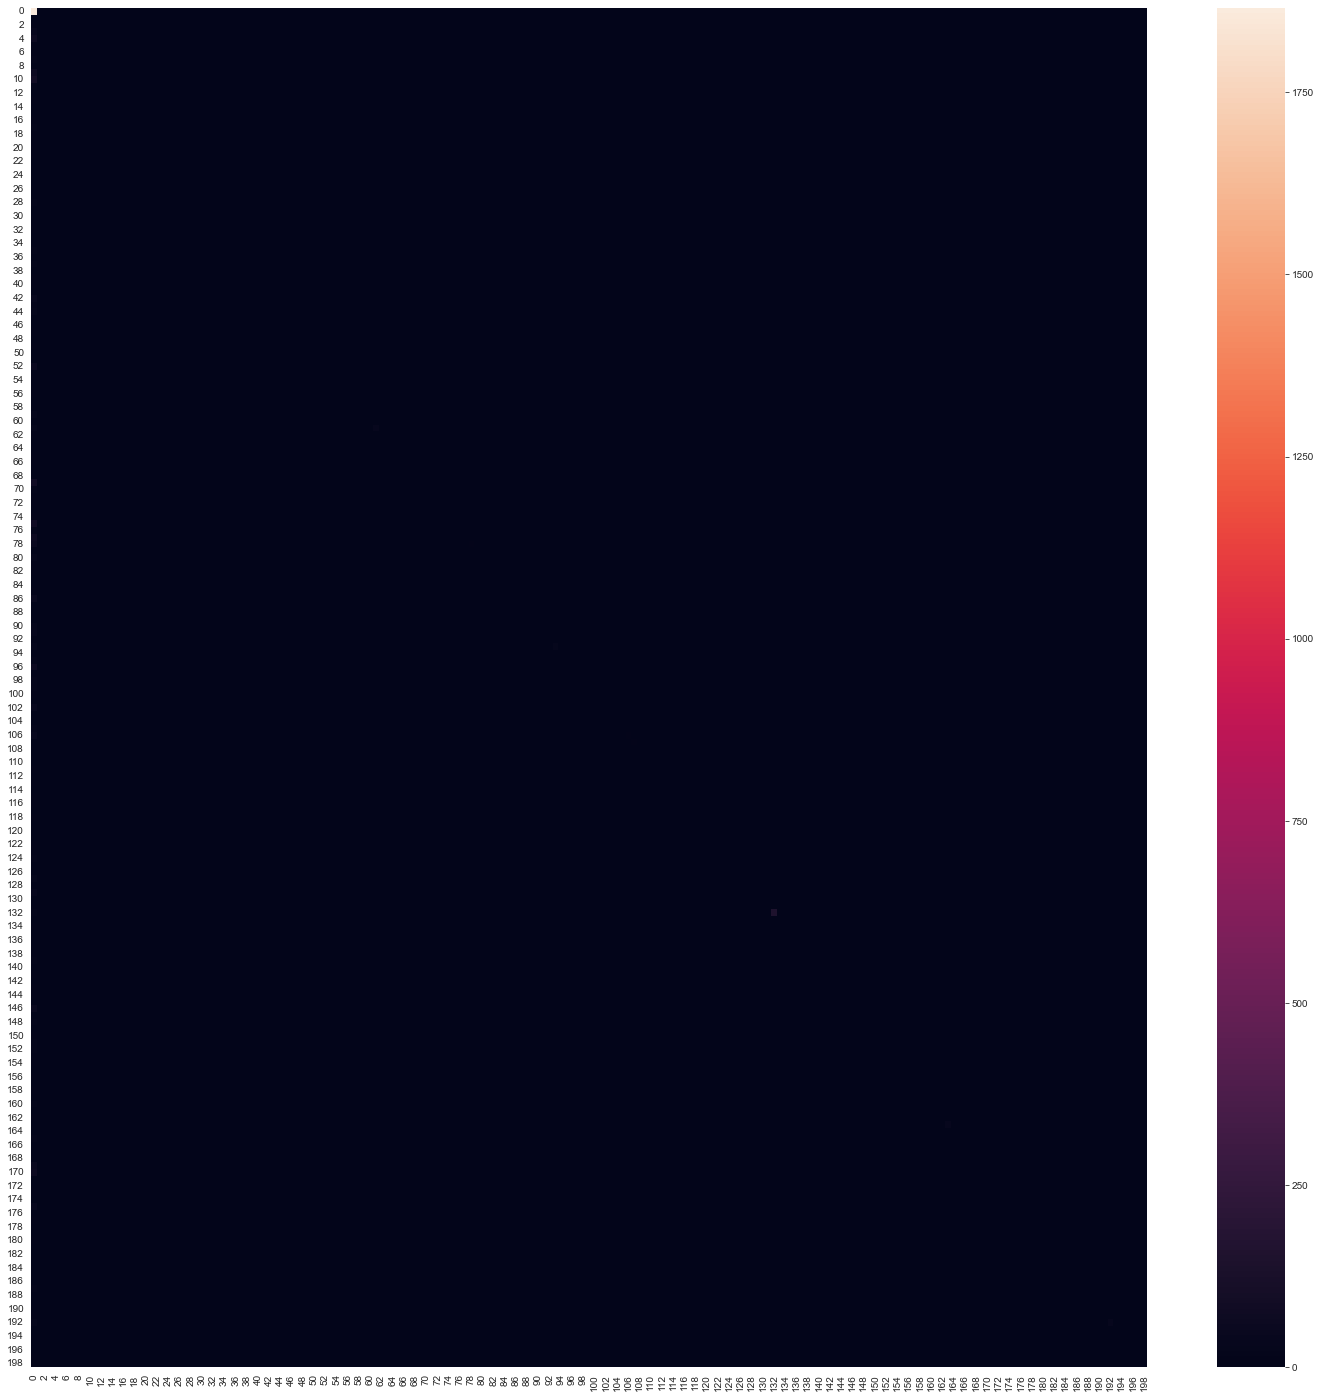

,param_alpha,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,True,"{'alpha': 0.1, 'fit_intercept': True}",-3.270085,-3.448378,-3.337374,-3.350265,-3.471038,-3.375428,0.074352,1
2,1,True,"{'alpha': 1, 'fit_intercept': True}",-3.270085,-3.448378,-3.337374,-3.350265,-3.471038,-3.375428,0.074352,1
4,10,True,"{'alpha': 10, 'fit_intercept': True}",-3.270085,-3.448378,-3.337374,-3.350265,-3.471038,-3.375428,0.074352,1
6,100,True,"{'alpha': 100, 'fit_intercept': True}",-3.279406,-3.452106,-3.330882,-3.352373,-3.472903,-3.377534,0.073614,4
7,100,False,"{'alpha': 100, 'fit_intercept': False}",-3.791181,-3.623508,-3.543126,-3.664816,-3.796014,-3.683729,0.097885,5


,train_score,test_score
KNeighborsClassifier_pca,-3.538129,-0.038128
RadiusNeighborsClassifier_pca,-3.759121,-0.0
MLPClassifier_pca,-5.858095,-0.115209
RidgeClassifier_pca,-3.43718,-0.041039
KNeighborsClassifier_vif5,-3.431297,-0.047151
RadiusNeighborsClassifier_vif5,-3.730667,-0.0
MLPClassifier_vif5,-6.051717,-0.159644
RidgeClassifier_vif5,-3.374081,-0.045405


In [35]:
rdg_params = {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}
model, performance = score_optimization(rdg_params, rdg_clf, [x_train, y_train, x_test, y_test], performance, log_scorer, model_label)
models.append(model)

# Choosing best model

After a couple of rounds trying different models and parameters, it doesn't seem that our models are performing very well.

In any case, due to a lack of additional time to work on the problem, we will take the best performing model: **MLPClassifier** after filtering the variables by a **maximum VIF of 5**.

In [41]:
models

[KNeighborsClassifier(leaf_size=10, n_neighbors=10),
 RadiusNeighborsClassifier(leaf_size=10, radius=100),
 MLPClassifier(learning_rate='adaptive', max_iter=1000, solver='sgd'),
 RidgeClassifier(alpha=100),
 KNeighborsClassifier(leaf_size=10, n_neighbors=10),
 RadiusNeighborsClassifier(leaf_size=10, radius=100),
 MLPClassifier(learning_rate='adaptive', max_iter=1000, solver='sgd'),
 RidgeClassifier(alpha=0.1),
 KNeighborsClassifier(leaf_size=10, n_neighbors=10)]

In [42]:
best_model = models[6]

Saving the chosen model for further predictions.

In [48]:
from pickle import dump

with open('./model.pkl', 'wb') as model:
    dump(best_model, model)

# Predicting test data

The test data needs to go over the same transformations previously done to the training data that the chosen model received.

In [53]:
test_data = pd.read_csv('test_data.csv')

# Initial transformations
test_data['id'] = X['id'].str.split('-', expand=True)[0]
test_data.set_index('id', inplace=True)

# Getting dummy variables
test_data['group'] = pd.get_dummies(test_data['group'], drop_first=True).values
test_data['dose'] = pd.get_dummies(test_data['dose'], drop_first=True).values

# Adjusting columns for VIF < 5
test_data = test_data[VIF_5]

# Rescaling the data
scaled_test_data = vif5_scaler.transform(test_data)

scaled_test_data = pd.DataFrame(scaled_test_data, index=test_data.index)
scaled_test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,0.0,0.0,1.0,0.454456,-0.062303,0.102011,0.174187,-0.242218,-0.245004,0.524494,...,-1.161339,0.165235,0.277993,-0.156835,-0.231580,0.305735,0.238762,0.285687,-0.716731,-0.616889
cb5223fc,0.0,0.5,1.0,-0.339489,-0.676765,0.070726,0.119867,0.499732,0.454001,1.209665,...,-1.385156,-0.327637,0.368173,0.794287,0.193065,-1.658120,-0.141212,1.815160,0.217868,0.591477
cb4eefd4,0.0,0.5,1.0,-0.436664,0.058786,-0.087263,-0.421193,-0.557782,-0.053770,1.083885,...,0.662317,-1.009442,1.052441,0.578742,0.149429,0.370849,0.793962,0.317599,-0.206454,-1.492078
cb597490,0.0,0.5,1.0,-0.347084,-0.213416,-0.103687,0.343242,0.270215,0.406410,0.920276,...,-0.140814,-0.181003,1.211679,-0.704415,-0.239657,-0.203562,-0.288826,-0.095545,0.584516,0.597856
cb54218e,0.0,0.5,0.0,-0.384851,0.369218,-1.367263,1.220915,-3.443023,2.271165,-1.131927,...,-2.220204,4.652913,6.826422,-2.783343,-0.993893,5.604880,1.116992,3.851049,-6.270188,-5.481621


In [56]:
test_predict = best_model.predict(scaled_test_data)
test_predict = pd.DataFrame(test_predict, columns=y_features.columns, index=test_data.index)
test_predict.head()

,mech-0,mech-1,mech-2,mech-3,mech-4,mech-5,mech-6,mech-7,mech-8,mech-9,...,mech-196,mech-197,mech-198,mech-199,mech-200,mech-201,mech-202,mech-203,mech-204,mech-205
id,,,,,,,,,,,,,,,,,,,,,
cb509e9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cb5223fc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cb4eefd4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cb597490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cb54218e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, the predictions are saved in a csv file for submission.

In [57]:
test_predict.to_csv('test_targets.csv')